In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import transforms, datasets

import os,PIL,pathlib,random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

: 

In [2]:
data_dir = './data/weather_photos/'
data_dir = pathlib.Path(data_dir)


data_paths = list(data_dir.glob('*'))

classeNames = [str(path).split("\\")[2] for path in data_paths]
classeNames

['cloudy', 'rain', 'shine', 'sunrise']

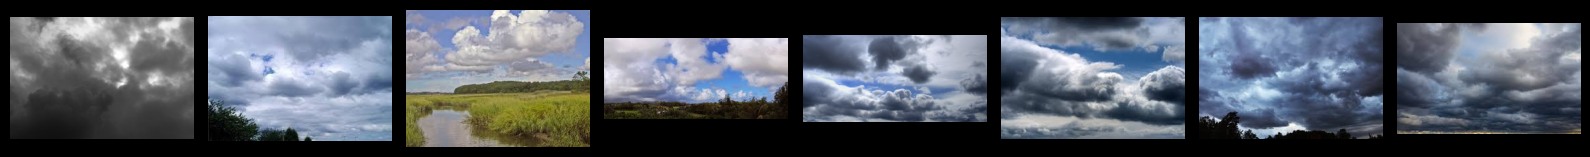

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# 指定图像文件夹路径
image_folder = './data/weather_photos/cloudy/'

# 获取文件夹中的所有图像文件
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

# 创建Matplotlib图像
fig, axes = plt.subplots(1, 8, figsize=(16, 6))

# 使用列表推导式加载和显示图像
for ax, img_file in zip(axes.flat, image_files):
    img_path = os.path.join(image_folder, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

# 显示图像
plt.tight_layout()
plt.show()

In [4]:
total_datadir = './data/weather_photos/'

# 关于transforms.Compose的更多介绍可以参考：https://blog.csdn.net/qq_38251616/article/details/124878863
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])

total_data = datasets.ImageFolder(total_datadir,transform=train_transforms)
total_data

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: ./data/weather_photos/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
train_size = int(0.8 * len(total_data))
test_size  = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x27dd8411820>,
 <torch.utils.data.dataset.Subset at 0x27dd8411c70>)

In [6]:
train_size,test_size

(900, 225)

In [7]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=1)

In [8]:
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


In [9]:
import torch.nn.functional as F

class Network_bn(nn.Module):
    def __init__(self):
        super(Network_bn, self).__init__()
        """
        nn.Conv2d()函数：
        第一个参数（in_channels）是输入的channel数量
        第二个参数（out_channels）是输出的channel数量
        第三个参数（kernel_size）是卷积核大小
        第四个参数（stride）是步长，默认为1
        第五个参数（padding）是填充大小，默认为0
        """
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*50*50, len(classeNames))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))      
        x = F.relu(self.bn2(self.conv2(x)))     
        x = self.pool(x)                        
        x = F.relu(self.bn4(self.conv4(x)))     
        x = F.relu(self.bn5(self.conv5(x)))  
        x = self.pool(x)                        
        x = x.view(-1, 24*50*50)
        x = self.fc1(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Network_bn().to(device)
model

Using cuda device


Network_bn(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=60000, out_features=4, bias=True)
)

In [10]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-4 # 学习率
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [11]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [12]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [13]:
epochs     = 20
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:56.6%, Train_loss:1.084, Test_acc:65.8%，Test_loss:1.117
Epoch: 2, Train_acc:73.4%, Train_loss:0.764, Test_acc:78.2%，Test_loss:0.683
Epoch: 3, Train_acc:79.9%, Train_loss:0.614, Test_acc:82.7%，Test_loss:0.537
Epoch: 4, Train_acc:82.8%, Train_loss:0.536, Test_acc:76.0%，Test_loss:0.616
Epoch: 5, Train_acc:84.0%, Train_loss:0.490, Test_acc:84.9%，Test_loss:0.483
Epoch: 6, Train_acc:86.1%, Train_loss:0.466, Test_acc:73.8%，Test_loss:0.805
Epoch: 7, Train_acc:86.2%, Train_loss:0.422, Test_acc:85.8%，Test_loss:0.427
Epoch: 8, Train_acc:88.7%, Train_loss:0.383, Test_acc:82.2%，Test_loss:0.460
Epoch: 9, Train_acc:89.7%, Train_loss:0.338, Test_acc:86.7%，Test_loss:0.388
Epoch:10, Train_acc:90.8%, Train_loss:0.357, Test_acc:84.9%，Test_loss:0.395
Epoch:11, Train_acc:90.3%, Train_loss:0.330, Test_acc:84.4%，Test_loss:0.376
Epoch:12, Train_acc:91.4%, Train_loss:0.357, Test_acc:87.1%，Test_loss:0.393
Epoch:13, Train_acc:91.1%, Train_loss:0.279, Test_acc:87.6%，Test_loss:0.364
Epoch:14, Tr

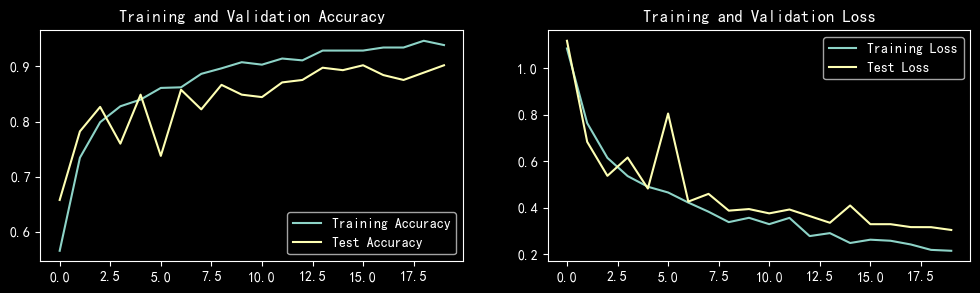

In [14]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()